In [82]:
from UZ_utils import *
from a4_utils import *
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import random

# Exercise 1: Feature points detectors

In [83]:
def gausian_kernel(sigma,N=None):

    if N is None:
    #limit to  2 ∗ ⌈3σ⌉ + 1
        N = int(2*np.ceil(3*sigma)+1)

    else:
        N = N//2
    #create a kernel .d from -N to N
    x = np.arange(-N,N+1)

    #calculate the kernel
    kernel = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-x**2/(2*sigma**2))

    #normalize the kernel
    kernel = kernel/np.sum(kernel)


    return (N,kernel)
    
#Implement a function that computes the derivative of a .-D Gaussian kernel
def gaussdx(sigma,N=None):
    if N is None:
        N = int(2*np.ceil(3*sigma)+1)

    else:
        N = N//2
    
    x = np.arange(-N,N+1)

    kernel = -x/(np.sqrt(2*np.pi)*sigma**3)*np.exp(-x**2/(2*sigma**2))

    #normalize the kernel by dividing the values such that the sum of absolute values is .
    kernel = kernel/np.sum(np.abs(kernel))

    return (N,kernel)

#Implement a function that uses functions gauss and gaussdx to compute both partial derivatives of a given image with respect to x and with respect to y.
def gaussderivatives(image, sigma):
    #get the kernel
    k1=gausian_kernel(sigma)[1]
    #make it into 2d
    G=k1.reshape(1,-1)
    GT=G.T

    #flip the kernel
    G=np.flip(G)
    GT=np.flip(GT)

    k2=gaussdx(sigma)[1]
    #make it into 2d
    D=k2.reshape(1,-1)
    Dt=D.T

    #flip the kernel
    D=np.flip(D)
    Dt=np.flip(Dt)

    #convolve the image with the kernels
    Ix=cv2.filter2D(cv2.filter2D(image, cv2.CV_64F, D), cv2.CV_64F, GT)
    Iy=cv2.filter2D(cv2.filter2D(image, cv2.CV_64F, G), cv2.CV_64F, Dt)

    return (Ix,Iy)


In [84]:
def nonmaxima_suppression(det,thresh,box_size):
    #get the size of the image
    h,w=det.shape

    #create a new image
    new_det=np.zeros((h,w))

    #loop through the image
    for i in range(h):
        for j in range(w):
            #if the value is above the threshold
            if det[i,j]>thresh:
                #get the box around the pixel the size is the width of the box around the pixel in x and y direction
                box=det[i-box_size//2:i+box_size//2+1,j-box_size//2:j+box_size//2+1]
                #get the maximum value in the box
                #handel empty boxes
                if box.size>0:

                    max_val=np.max(box)
                else:
                    max_val=0
                #if the value is the maximum in the box
                if det[i,j]==max_val:
                    #set the value to 1
                    new_det[i,j]=1
    return new_det

In [85]:
def hessian_points(I, sigma, thresh):
    """
    Compute the hessian points for a given image and sigma
    :param I: input image
    :param sigma: sigma value
    :param thresh: threshold value
    :return: hessian points
    """



    #get the derivatives
    Ix,Iy=gaussderivatives(I,sigma)

    # #show the derivatives
    # plt.imshow(Ix,cmap='gray')
    # plt.show()
    # plt.imshow(Iy,cmap='gray')
    # plt.show()

    #get the second derivatives
    Ixx,Ixy=gaussderivatives(Ix,sigma)
    Iyx,Iyy=gaussderivatives(Iy,sigma)

    # #show the second derivatives
    # plt.imshow(Ixx,cmap='gray')
    # plt.show()
    # plt.imshow(Ixy,cmap='gray')
    # plt.show()
    # plt.imshow(Iyx,cmap='gray')
    # plt.show()
    # plt.imshow(Iyy,cmap='gray')
    # plt.show()

    #fill the hessian matrix
    H=np.zeros((I.shape[0],I.shape[1],2,2))
    H[:,:,0,0]=Ixx
    H[:,:,0,1]=Ixy
    H[:,:,1,0]=Iyx
    H[:,:,1,1]=Iyy

    #compute the determinant 

    det= H[:,:,0,0]*H[:,:,1,1]-H[:,:,0,1]*H[:,:,1,0] 

    #threshold the determinant

    nonmaxima=nonmaxima_suppression(det,thresh,3)

    return nonmaxima





    





34


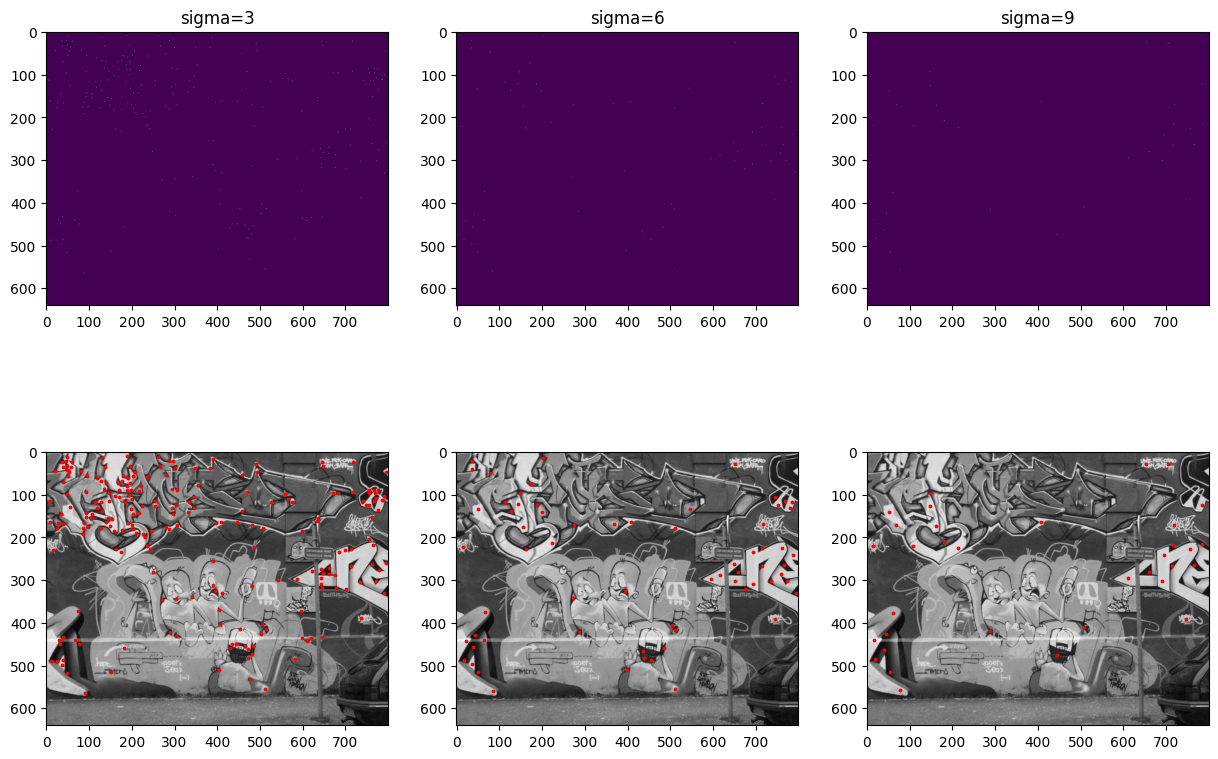

In [86]:
#test_points.jpg

#open the image grey scale
image = imread_gray('data/graf/graf_a.jpg')
thresh=0.004
sigma=3

#compute the hessian points
det3 = hessian_points(image, 3, thresh)
det6 = hessian_points(image, 6, thresh)
det9 = hessian_points(image, 9, thresh)



#make 3 wide and 2 high 
fig, axs = plt.subplots(2, 3,figsize=(15,10))

#plot the dets int he first row
axs[0,0].imshow(det3)
axs[0,0].set_title('sigma=3')
axs[0,1].imshow(det6)
axs[0,1].set_title('sigma=6')
axs[0,2].imshow(det9)
axs[0,2].set_title('sigma=9')




#add scatter plot with the points the shape of X
axs[1,0].imshow(image,cmap='gray')
axs[1,0].scatter(np.where(det3==1)[1],np.where(det3==1)[0],s=3,c='r')
axs[1,1].imshow(image,cmap='gray')
axs[1,1].scatter(np.where(det6==1)[1],np.where(det6==1)[0],s=3,c='r')
axs[1,2].imshow(image,cmap='gray')
axs[1,2].scatter(np.where(det9==1)[1],np.where(det9==1)[0],s=3,c='r')

#count the points

print(len(np.where(det9==1)[1]))



plt.show()






In [87]:
def harris_points(I, sigma, thresh=0):

    harris = np.zeros(I.shape)

    sigma2 = 1.6 * sigma
    size = round(2 * 3 * sigma2 + 1)
    alpha = 0.06

    #create the 2d gaussian kernel
    G = gausian_kernel(sigma2,size)[1]
    G = G.reshape(1, -1)
    GT = G.T


    #get the derivatives

    Ix,Iy=gaussderivatives(I,sigma)
    

    #correlation matrix C 
    C = np.zeros((I.shape[0], I.shape[1], 2, 2))

    #the first element is G sigma2 * Ix^2
    #the second element is G sigma2 * Ix * Iy
    #the third element is G sigma2 * Ix * Iy
    #the fourth element is G sigma2 * Iy^2
    # * is convolution
    C[:, :, 0, 0] = cv2.filter2D(cv2.filter2D(Ix * Ix, cv2.CV_64F, G), cv2.CV_64F, GT)
    C[:, :, 0, 1] = cv2.filter2D(cv2.filter2D(Ix * Iy, cv2.CV_64F, G), cv2.CV_64F, GT)
    C[:, :, 1, 0] = cv2.filter2D(cv2.filter2D(Ix * Iy, cv2.CV_64F, G), cv2.CV_64F, GT)
    C[:, :, 1, 1] = cv2.filter2D(cv2.filter2D(Iy * Iy, cv2.CV_64F, G), cv2.CV_64F, GT)

    #compute the determinant and trace
    det = C[:, :, 0, 0] * C[:, :, 1, 1] - C[:, :, 0, 1] * C[:, :, 1, 0]
    trace = C[:, :, 0, 0] + C[:, :, 1, 1]
    # express the feature point condition for (x, y)
    harris = det - alpha * trace * trace

    #apply the nonmaxima suppression
    harris = nonmaxima_suppression(harris.copy(), thresh, 3)

    









    return harris






   







80


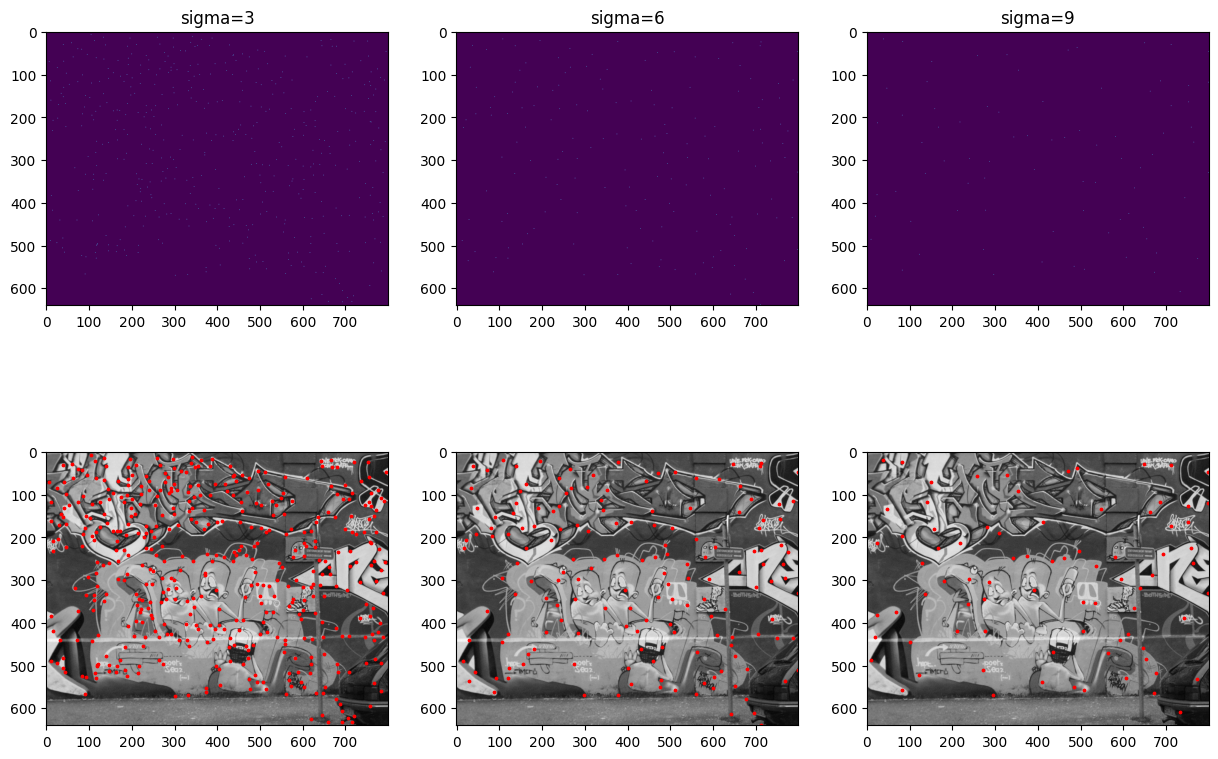

In [88]:
#test_points.jpg

#open the image grey scale
image = imread_gray('data/graf/graf_a.jpg')
#1e−6
thresh=0.000001
sigma=3

#compute the hessian points
det3 = harris_points(image, 3, thresh)
det6 = harris_points(image, 6, thresh)
det9 = harris_points(image, 9, thresh)



#make 3 wide and 2 high 
fig, axs = plt.subplots(2, 3,figsize=(15,10))

#plot the dets int he first row
axs[0,0].imshow(det3)
axs[0,0].set_title('sigma=3')
axs[0,1].imshow(det6)
axs[0,1].set_title('sigma=6')
axs[0,2].imshow(det9)
axs[0,2].set_title('sigma=9')




#add scatter plot with the points the shape of X
axs[1,0].imshow(image,cmap='gray')
axs[1,0].scatter(np.where(det3==1)[1],np.where(det3==1)[0],s=3,c='r')
axs[1,1].imshow(image,cmap='gray')
axs[1,1].scatter(np.where(det6==1)[1],np.where(det6==1)[0],s=3,c='r')
axs[1,2].imshow(image,cmap='gray')
axs[1,2].scatter(np.where(det9==1)[1],np.where(det9==1)[0],s=3,c='r')

#count the points

print(len(np.where(det9==1)[1]))



plt.show()




# Exercise 2: Matching local regions

In [89]:
def find_correspondences(D1,D2,sss=False):

    #d is  tensor of shape (len(X), 16^2)
    #d[i] is the descriptor of the ith point

    #Use Hellinger distance Finally, for each descriptor from the first list,
    #  find the most similar descriptor from the second list. Return a list of [a, b] pairs,
    #  where a is the index from the first list, and b is the index from the second list.

    #d has a set of descriptors for each point
    #d[i] is the descriptor of the ith point

    #we want to find the most similar descriptor from the second list
    #for each descriptor in the first list

    #we will use the hellinger distance
    #d1 is the descriptor of the first list

    list_of_pairs=[]
    for i in range(len(D1)):
        #go through each descriptor in the first list and find the most similar descriptor in the second list
        d1=D1[i]

       

        #make a list of the distances numpy array
        distances=np.zeros(len(D2))
    

        for j in range(len(D2)):
            d2=D2[j]
            #compute the hellinger distance
            hellinger_distance=np.sqrt(np.sum((np.sqrt(d1)-np.sqrt(d2))**2))
            distances[j]=hellinger_distance

        
        #find the smallest distance
        smallest_distance=np.min(distances)
        second_smallest_distance=np.sort(distances)[1]
        
        smallest_index=np.argmin(distances)

        if sss:

            ratio=smallest_distance/second_smallest_distance
            if ratio<0.95:
                list_of_pairs.append([i,smallest_index])
            #only add the pair if the smallest distance is less than 0.8 times the second smallest distance
        else:
            list_of_pairs.append([i,smallest_index])
   

    return list_of_pairs



    

            


    
    
            

   





In [90]:
def to_list(xPoint, yPoint):

    points = []

    for i in range(len(xPoint)):
        x = xPoint[i]
        y = yPoint[i]
        points.append((x, y))

    return points

In [91]:
def find_matches(I1,I2,sss=False):
    
        #find the harris points
        det1 = harris_points(I1, 3, 0.0000001)
        det2 = harris_points(I2, 3, 0.0000001)
       
    
        #get the points
        x1 = np.where(det1 == 1)[1]
        y1 = np.where(det1 == 1)[0]
        x2 = np.where(det2 == 1)[1]
        y2 = np.where(det2 == 1)[0]
    
        #get the descriptors
        D1 = simple_descriptors(I1,y1,x1)
        D2 = simple_descriptors(I2,y2,x2)
    
        #find the correspondences
        correspondences1 = find_correspondences(D1, D2,sss)
        correspondences2 = find_correspondences(D2, D1,sss)

        correspondences2=[t[::-1] for t in correspondences2]

        #find the symmetric correspondences
        symmetric_correspondences=[]
        for i in range(len(correspondences1)):
                if correspondences1[i] in correspondences2:
                        symmetric_correspondences.append(correspondences1[i])

        

        


        return symmetric_correspondences,to_list(x1,y1),to_list(x2,y2)
    

    
        

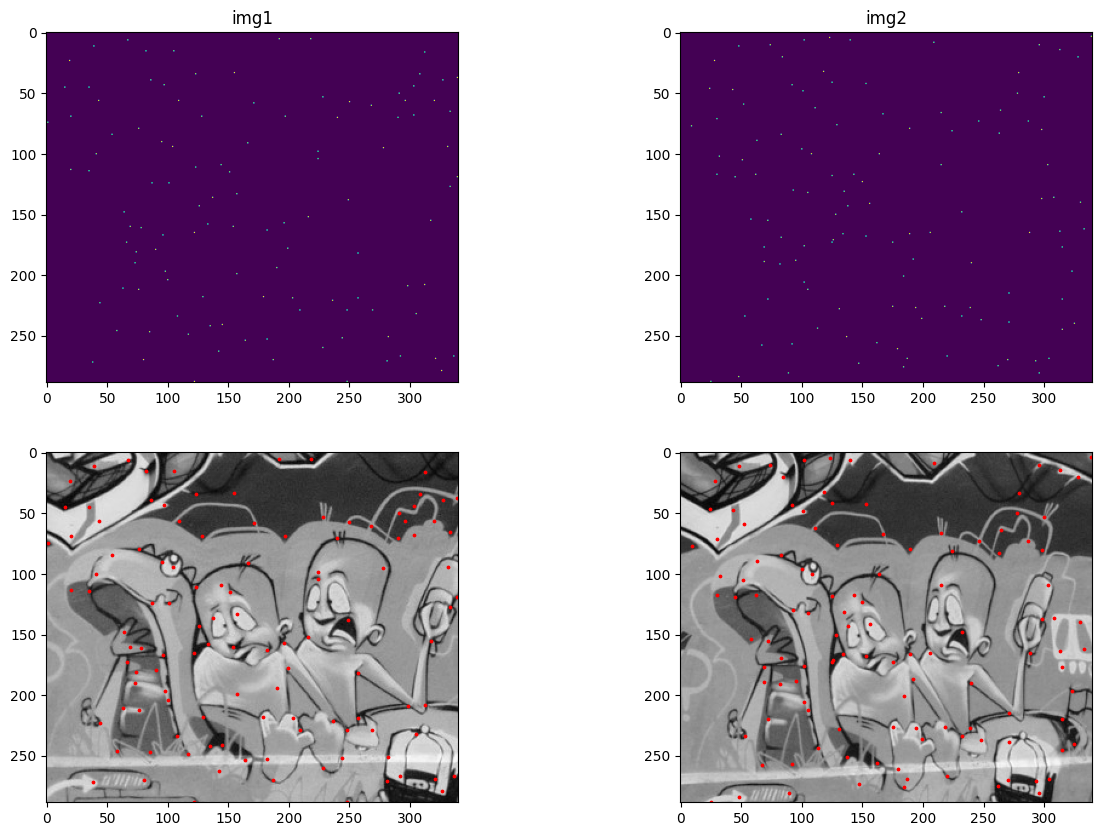

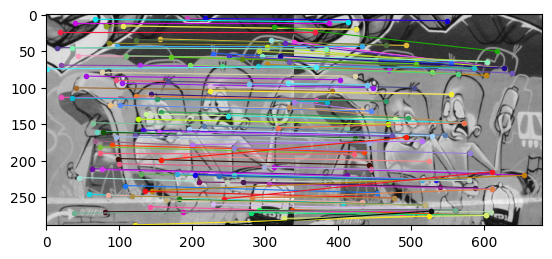

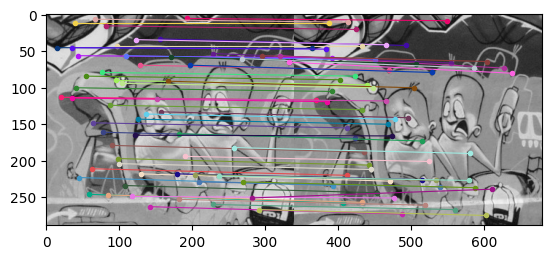

In [92]:
#graf/graf_a_small.jpg
I1=imread_gray('data/graf/graf_a_small.jpg')
I2=imread_gray('data/graf/graf_b_small.jpg')

#get harris points
harris1 = harris_points(I1, 3, 0.0000001)
harris2 = harris_points(I2, 3, 0.0000001)

#make 3 wide and 2 high
#show with img1 and img2 and scatter plot
fig, axs = plt.subplots(2, 2,figsize=(15,10))

#plot the dets int he first row
axs[0,0].imshow(harris1)
axs[0,0].set_title('img1')
axs[0,1].imshow(harris2)
axs[0,1].set_title('img2')

#add scatter plot with the points the shape of X
axs[1,0].imshow(I1,cmap='gray')
axs[1,0].scatter(np.where(harris1==1)[1],np.where(harris1==1)[0],s=3,c='r')
axs[1,1].imshow(I2,cmap='gray')
axs[1,1].scatter(np.where(harris2==1)[1],np.where(harris2==1)[0],s=3,c='r')

plt.show()



points1=to_list(np.where(harris1==1)[1],np.where(harris1==1)[0])
points2=to_list(np.where(harris2==1)[1],np.where(harris2==1)[0])
#get all x coordinates in a list
x1=np.where(harris1==1)[1]
y1=np.where(harris1==1)[0]
x2=np.where(harris2==1)[1]
y2=np.where(harris2==1)[0]

desc1 = simple_descriptors(I1, y1, x1)
desc2 = simple_descriptors(I2, y2, x2)

correspondences = find_correspondences(desc1, desc2)

#turn correspondences into a list of points for each image
#corespondences is a list of [a,b] pairs where a is the index of the first list and b is the index of the second list
#loop through the correspondences and get the points from the first list and the second list

common_points1=[]
common_points2=[]
for a,b in correspondences:
    common_points1.append(points1[a])
    common_points2.append(points2[b])

        



# #display the matches
display_matches(I1, common_points1, I2, common_points2)


csymetric,_,_= find_matches(I1,I2)

#turn correspondences into a list of points for each image
common_points1=[]
common_points2=[]
for a,b in csymetric:
    common_points1.append(points1[a])
    common_points2.append(points2[b])

#display the matches
display_matches(I1, common_points1, I2, common_points2)














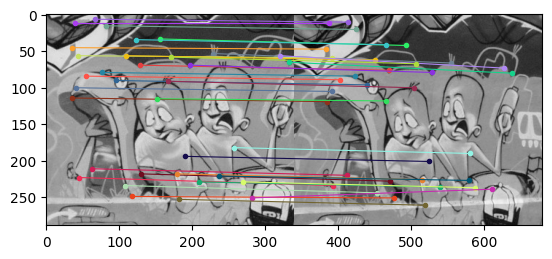

In [93]:
#Calculate the distance between A and the second-most similar keypoint
# and the most similar keypoint and in the right image.
# • Ratio of these two distances (first/second) will be low for distinctive key-points and
# high for non-distinctive ones.

#find the distances between the first and second most similar keypoint

c_upgraded,_,_= find_matches(I1,I2,sss=True)

#turn correspondences into a list of points for each image
common_points1=[]
common_points2=[]
for a,b in c_upgraded:
    common_points1.append(points1[a])
    common_points2.append(points2[b])

#display the matches
display_matches(I1, common_points1, I2, common_points2)

# Exercize 3 Homoegraphy estimation

In [94]:
def read_data(file):

    data = file.read()
    data = data.split()
    data = np.array(data)
    data = np.copy(data.astype(np.float64))
    data = data.reshape((4, 4))

    pointsI1temp = data[:, :2]
    pointsI2temp = data[:, -2:]

    pointsI1 = []
    pointsI2 = []

    for i in range(0, 4):
        pointsI1.append((pointsI1temp[i][0], pointsI1temp[i][1]))
        pointsI2.append((pointsI2temp[i][0], pointsI2temp[i][1]))

    matches = []

    for i in range(0, 4):
        matches.append((i, i))

    return (pointsI1, pointsI2, matches)

In [95]:
def estimate_homography(pointsI,pointsJ,matches):
    #Construct a matrix A using the equations from the lecture notes
    
    A = np.zeros((2*len(matches),9))
    for i in range(len(matches)):
        x1,y1=pointsI[matches[i][0]]
        x2,y2=pointsJ[matches[i][1]]
        A[2*i]=[x1,y1,1,0,0,0,-x2*x1,-x2*y1,-x2]
        A[2*i+1]=[0,0,0,x1,y1,1,-y2*x1,-y2*y1,-y2]

    #Perform a matrix decomposition using the SVD algorithm
    U, S, V = np.linalg.svd(A)
   #compute vector h from the last column of V
    h = V[-1] / V[-1, -1]  
    
    H = h.reshape(3, 3)
    #transpose H
    return H


    


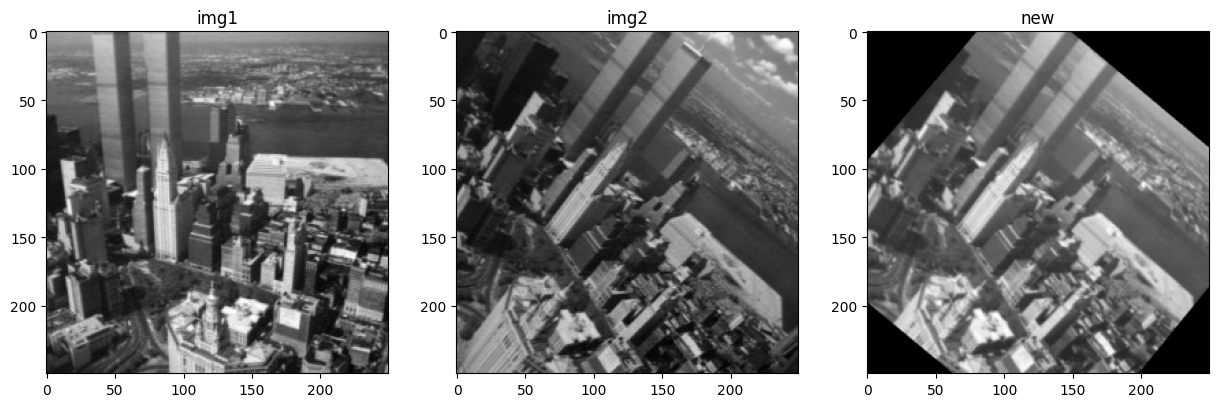

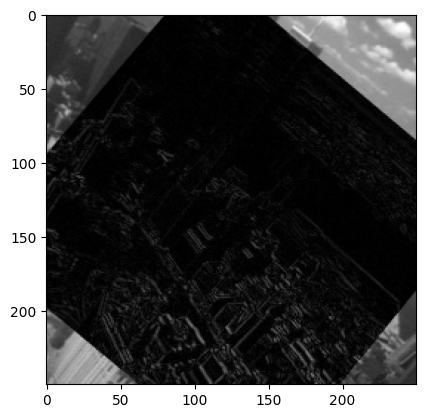

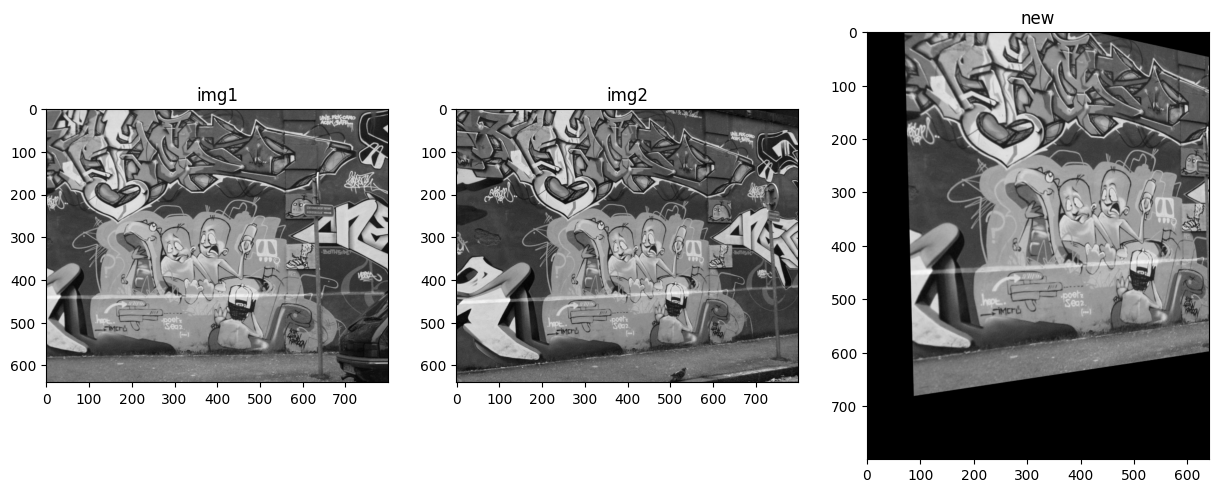

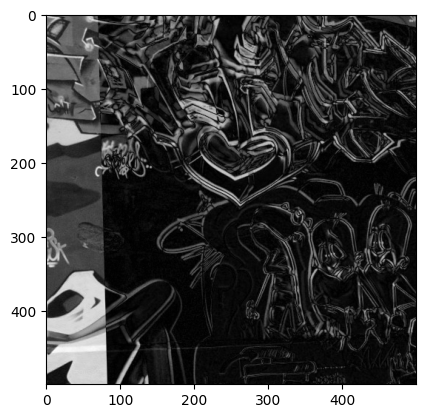

In [98]:
#readdata/newyork/newyork1.jpg
I1=imread_gray('data/newyork/newyork_a.jpg')
I2=imread_gray('data/newyork/newyork_b.jpg')

file = open('data/newyork/newyork.txt', 'r')

(pointsI1, pointsI2, matches) = read_data(file)
H = estimate_homography(pointsI1, pointsI2, matches)

#display the matches
new = cv2.warpPerspective(I1, H, I1.shape)
#display original images and the new image
fig, axs = plt.subplots(1, 3,figsize=(15,10))
axs[0].imshow(I1,cmap='gray')
axs[0].set_title('img1')
axs[1].imshow(I2,cmap='gray')
axs[1].set_title('img2')
axs[2].imshow(new,cmap='gray')
axs[2].set_title('new')
plt.show()

#show difference between the two images with overlay
diff = np.abs(I2 - new)
plt.imshow(diff,cmap='gray')
plt.show()


#open graph images
I1=imread_gray('data/graf/graf_a.jpg')
I2=imread_gray('data/graf/graf_b.jpg')

#open graf text file
file = open('data/graf/graf.txt', 'r')

(pointsI1, pointsI2, matches) = read_data(file)
H = estimate_homography(pointsI1, pointsI2, matches)

#display the matches
new = cv2.warpPerspective(I1, H, I1.shape)



#display original images and the new image
fig, axs = plt.subplots(1, 3,figsize=(15,10))
axs[0].imshow(I1,cmap='gray')
axs[0].set_title('img1')
axs[1].imshow(I2,cmap='gray')
axs[1].set_title('img2')
axs[2].imshow(new,cmap='gray')
axs[2].set_title('new')
plt.show()

#show difference between the two images with overlay and crop to the same size
#crop both to the same size
I1=I1[0:500,0:500]
I2=I2[0:500,0:500]
new=new[0:500,0:500]
diff = np.abs(I2 - new)
plt.imshow(diff,cmap='gray')

plt.show()







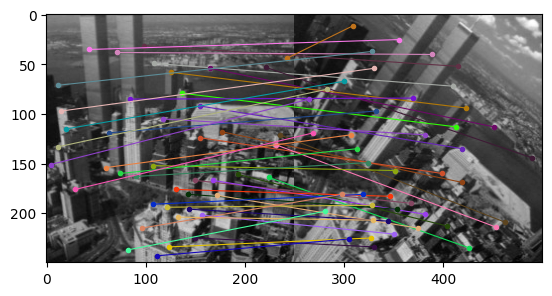

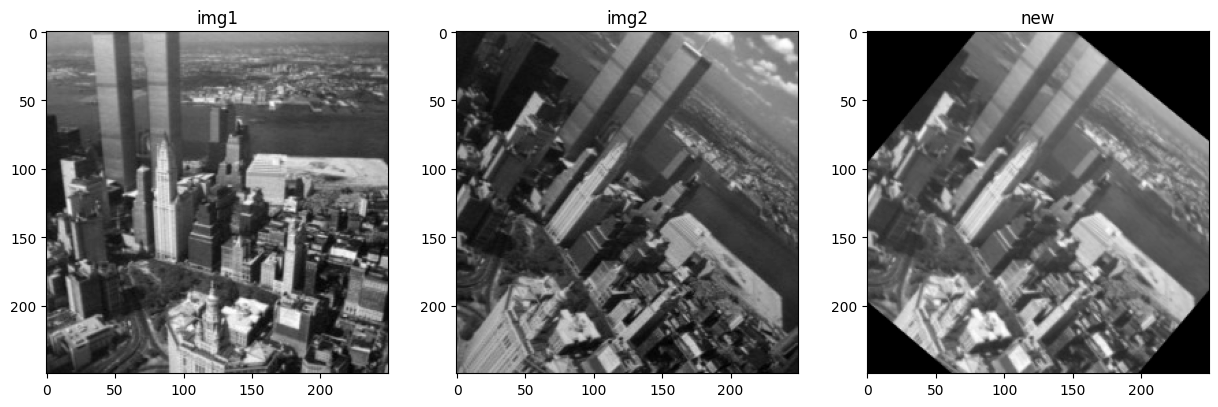

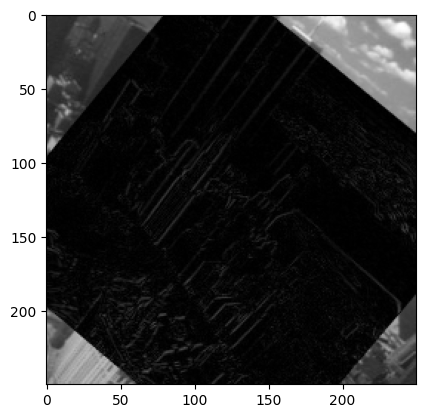

In [97]:
#Using the find_matches function that you have implemented in the previous exercise,
#  find a set of matched points from either the graf or newyork image pairs.
#  Then, implement the RANSAC algorithm for robust estimation of the homography

#open newyork images
I1=imread_gray('data/newyork/newyork_a.jpg')
I2=imread_gray('data/newyork/newyork_b.jpg')

#use find_matches to find the matches

matches,points1,points2=find_matches(I1,I2)

common_points1=[]
common_points2=[]
for a,b in matches:
    common_points1.append(points1[a])
    common_points2.append(points2[b])

display_matches(I1, common_points1, I2, common_points2)



#estimate the homography using the matches with RANSAC

bestH = None
bestInliers = None
bestInlierCount = 0

for i in range(100):
    #select 4 random points
    randomPoints = random.sample(matches, 4)
    #estimate the homography using the random points
    H = estimate_homography(points1, points2, randomPoints)
    #find the inliers
    inliers = []
    for point in matches:
        x1,y1=points1[point[0]]
        x2,y2=points2[point[1]]
        x1 = np.array([x1, y1, 1])
        x2 = np.array([x2, y2, 1])
        x1 = x1.reshape(3, 1)
        x2 = x2.reshape(3, 1)
        #calculate the distance use euclidean distance
        distance = np.linalg.norm(np.dot(H, x1) - x2)
        if distance < 3:
            inliers.append(point)
    #if the number of inliers is greater than the best number of inliers
        
    #check if the number of inliers is greater than the best number of inliers
    if len(inliers) > bestInlierCount:
        bestInlierCount = len(inliers)
        bestInliers = inliers
        bestH = H


#display the matches
new = cv2.warpPerspective(I1, bestH, I1.shape)
#display original images and the new image
fig, axs = plt.subplots(1, 3,figsize=(15,10))
axs[0].imshow(I1,cmap='gray')
axs[0].set_title('img1')
axs[1].imshow(I2,cmap='gray')
axs[1].set_title('img2')
axs[2].imshow(new,cmap='gray')
axs[2].set_title('new')
plt.show()

#show difference between the two images with overlay
diff = np.abs(I2 - new)
plt.imshow(diff,cmap='gray')
plt.show()

